## Soleil DiffAbs XRD:
* [Calibration](#calibration)
* [Integration](#integration)

## Calibration <a name="calibration"></a>

This tutorial is for the calibration of an Xpad_flat on the Soleil Diffabs Diffractometer.

The calibration data is a scan on the delta motor with a CeO2 calibrant.

In [1]:
%matplotlib notebook

# first the imports
from typing import Iterator, List, NamedTuple, Text, Tuple

import os
import functools

from collections import namedtuple
from math import pi

import numpy
import pylab
import pyFAI

import ipywidgets as widgets

from h5py import Dataset, File
from IPython.display import display
from numpy import ndarray
from pyFAI.gui import jupyter

# local import
from soleil import Angle, Calibrant, Calibration, CalibrationFunctions, CalibrationFrame, DatasetPathContains, DatasetPathWithAttribute, \
    Detector, Length, Parameter, Wavelength, \
    calibration, integrate, save_as_edf

In [2]:
# temporary until the ruch is ON
ROOT = os.path.join("/nfs", "ruche-diffabs", "diffabs-soleil", "com-diffabs", "2016", "Run4")

PUBLISHED = os.path.join("/nfs", "ruche-diffabs", "diffabs-soleil", "com-diffabs", "2016", "Run4B", "OutilsMetallo_CarolineHamon")

In [3]:
# do a calibration with a well centered sample.

# TODO recuperer le point de départ à partir des ponis de référence.
# TODO ajouter le diagramme complet à la fin.
# TODO ajout du mask pour la calibration

json = os.path.join(PUBLISHED, "xrd-test", "calibration", "calibration.json")

distance = Length(3.88099e-01)
poni1 = Length(1.307413e-01)
poni2 = Length(3.010775e-02)
rot1_scale = pi / 180.0  # convert degree to radian
rot1_offset = Angle(-0.008)  # radian
rot2_scale = pi / 180.0  # convert degree to radian
rot2_offset = Angle(0.319310040993)  # radian
rot3 = Angle(7.19961198098e-07)

functions = (
    CalibrationFunctions("dist", "poni1", "poni2",
                         "rot1_scale * delta + rot1_offset",
                         "rot2_scale * delta + rot2_offset",
                         "rot3"),
    [Parameter[Length]("dist", distance, (distance-0.01, distance+0.01)),
     Parameter[Length]("poni1", poni1, (poni1-0.1, poni1+0.1)),
     Parameter[Length]("poni2", poni2, (poni2-0.1, poni2+0.1)),
     Parameter[float]("rot1_scale", rot1_scale, (0, rot1_scale)),
     Parameter[Angle]("rot1_offset", rot1_offset, (rot1_offset-0.5, rot1_offset+0.5)),
     Parameter[float]("rot2_scale", rot2_scale, (rot2_scale, rot2_scale)),
     Parameter[Angle]("rot2_offset", rot2_offset, (rot2_offset-0.5, rot2_offset+0.5)),
     Parameter[Angle]("rot3", rot3, (rot3-0.1, rot3+0.1))]
)

def to_use(frame: CalibrationFrame) -> bool:
    return True if frame.idx in range(0,70) else False

params = Calibration(os.path.join(PUBLISHED, "xrd-test", "calibration"),
                     os.path.join(ROOT, "2016-09-07", "IHR_30.nxs"),
                     DatasetPathWithAttribute("interpretation", b"image"),
                     DatasetPathContains("scan_data/actuator_1_1"),
                     [5, 32, 68],
                     to_use,
                     Calibrant("CeO2"),
                     Detector("Xpad_flat"),
                     Wavelength(6.8877e-11),
                     functions
                    )

In [4]:
from functools import partial

def on_click_button(cmd, b):
    ! {cmd}
    
def my_cmd_button(cmd, description):
    # Click the button to open the data with silx
    button = widgets.Button(
        description=description,
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Click me',
        icon='check',
        layout = widgets.Layout(width='auto')
    )

    display(button)

    button.on_click(partial(on_click_button, cmd))

    return button

In [5]:
silx = my_cmd_button("silx view --use-opengl-plot {params.filename}",
                     'Silx View ' + os.path.basename(params.filename))

ERROR:silx.app.view:Filename '{params.filename}' must be a file path


In [6]:
# save all the ref as images in order to do the calibration with
# pyFAI-calib[2].
# temporary until pyFAI-calib2 can read from NeXuS files.

cmds = save_as_edf(params)
for cmd, idx in zip(cmds, params.idxs):
    my_cmd_button(cmd, 'PyFAI-calib2 ' + os.path.basename(params.filename) + " " + str(idx))

Gtk-Message: Failed to load module "canberra-gtk-module"
  File "/usr/lib/python2.7/dist-packages/silx/gui/plot/PlotActions.py", line 38, in <module>
    since_version='0.6')
CeO2 Calibrant with 41 reflections 
CeO2 Calibrant with 41 reflections 
Gtk-Message: Failed to load module "canberra-gtk-module"
  File "/usr/lib/python2.7/dist-packages/silx/gui/plot/PlotActions.py", line 38, in <module>
    since_version='0.6')
CeO2 Calibrant with 41 reflections 
CeO2 Calibrant with 41 reflections 


In [ ]:
# execute the calibration

calibration(json, params)

<IPython.core.display.Javascript object>


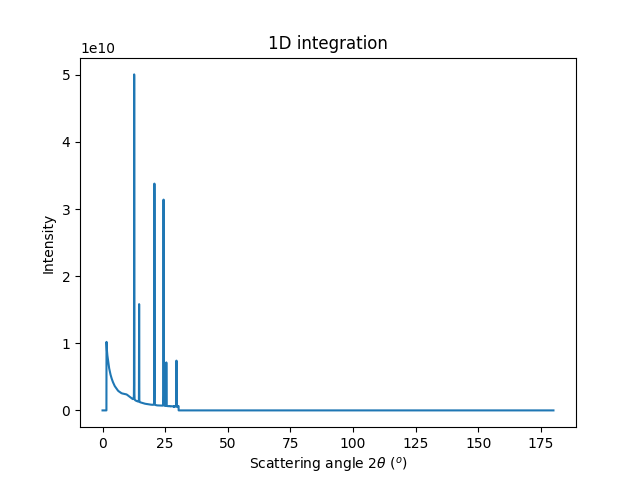

In [8]:
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 20000, 0, img)
    return img

integrate(json, params, f, plot_calibrant=True)

## Integration <a name="integration"></a>

<IPython.core.display.Javascript object>


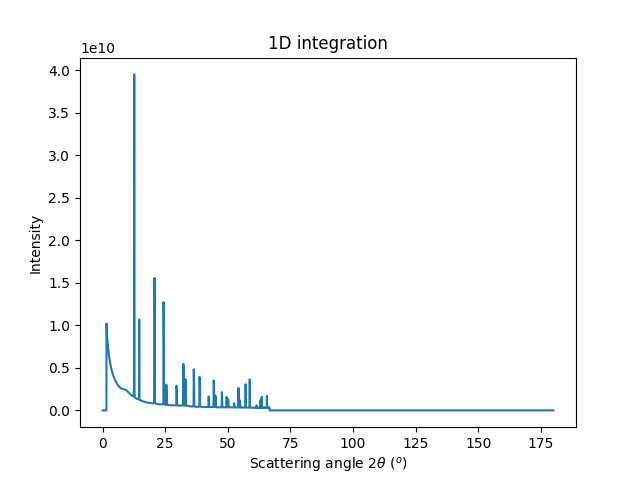

In [7]:
# integrate all the diffractogram

# let's take all the images
def to_use_sample(frame: CalibrationFrame) -> bool:
    return True

ceo2 = Calibration(os.path.join(PUBLISHED, "xrd-test", "calibration"),
                   os.path.join(ROOT, "2016-09-07", "IHR_30.nxs"),
                   DatasetPathWithAttribute("interpretation", b"image"),
                   DatasetPathContains("scan_data/actuator_1_1"),
                   [5, 32, 68],
                   to_use_sample,
                   Calibrant("CeO2"),
                   Detector("Xpad_flat"),
                   Wavelength(6.8877e-11),
                   functions
                   )

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 20000, 0, img)
    return img

integrate(json, ceo2, f)